In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import dotenv
dotenv.load_dotenv("/home/ckj24/rna-inverse-folding/.env")

True

In [2]:
import dotenv
dotenv.load_dotenv(".env")

import os
import random
import argparse
import wandb
import numpy as np
import pandas as pd

from lovely_numpy import lo
import lovely_tensors as lt
lt.monkey_patch()

import torch

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


In [9]:
# structsim split
model_name_to_dir = {
    "1 state": "/home/ckj24/rna-inverse-folding/wandb/run-20240117_081314-70bhmvy0/",
    "3 states": "/home/ckj24/rna-inverse-folding/wandb/run-20240117_085918-8q5xb7oh/",
    "5 states": "/home/ckj24/rna-inverse-folding/wandb/run-20240117_090005-i2wmb3bu/"
}

In [10]:
# load test set results for each model

df_residue = pd.DataFrame(columns=['idx', 'recovery', 'sasa', 'paired', 'rmsds', 'model_name', 'set'])

df_sample = pd.DataFrame(columns=['idx', 'mean_recovery', 'mean_scscore', 'model_name', 'set'])

for model_name, dir in model_name_to_dir.items():
    print(model_name)
    
    test_df, test_samples_list, test_recovery_list, test_scscore_list = torch.load(os.path.join(dir, "files", "test_results.pt"))
    test_df["model_name"] = model_name
    test_df["set"] = "test"
    
    df_residue = pd.concat([df_residue, test_df], axis=0)

    df_sample = pd.concat([df_sample, pd.DataFrame({
        "idx": list(range(len(test_recovery_list))),
        "mean_recovery": np.array(test_recovery_list),
        "mean_scscore": np.array(test_scscore_list),
        "model_name": [model_name] * len(test_recovery_list),
        "set": ["test"] * len(test_samples_list)
    })], axis=0)

    print(f"    TEST recovery: {np.mean(test_recovery_list):.4f} scscore: {np.mean(test_scscore_list):.4f}\n")

1 state
    TEST recovery: 0.4547 scscore: 0.5782

3 states
    TEST recovery: 0.4692 scscore: 0.5957

5 states
    TEST recovery: 0.4844 scscore: 0.5841



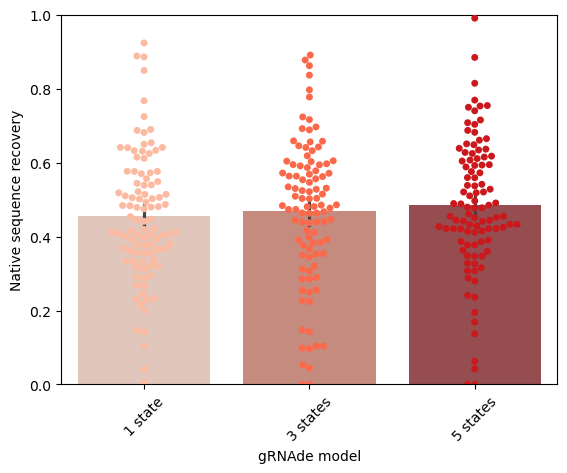

In [20]:
# bar plots comparing models to Rosetta and FARNA (only recovery is available)

sns.swarmplot(
    data = df_sample,
    x="model_name",
    y="mean_recovery",
    # order = ["FARNA", "Rosetta", ...],
    # hue="set",
    palette="Reds",
)

sns.barplot(
    data = df_sample,
    x="model_name",
    y="mean_recovery",
    # order = ["FARNA", "Rosetta", ...],
    # hue="set",
    saturation=0.4,
    palette="Reds",
)

# rotate x-axis labels
plt.xticks(rotation=45)

plt.xlabel("gRNAde model")
plt.ylabel("Native sequence recovery")
plt.ylim(0, 1)

plt.show()

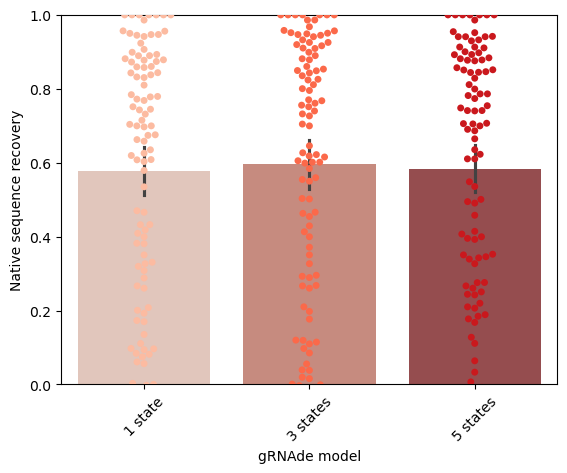

In [18]:
# bar plots comparing models to Rosetta and FARNA (only recovery is available)

sns.swarmplot(
    data = df_sample,
    x="model_name",
    y="mean_scscore",
    palette="Reds",
)

sns.barplot(
    data = df_sample,
    x="model_name",
    y="mean_scscore",
    saturation=0.4,
    palette="Reds",
)

# rotate x-axis labels
plt.xticks(rotation=45)

plt.xlabel("gRNAde model")
plt.ylabel("Native sequence recovery")
plt.ylim(0, 1)

plt.show()

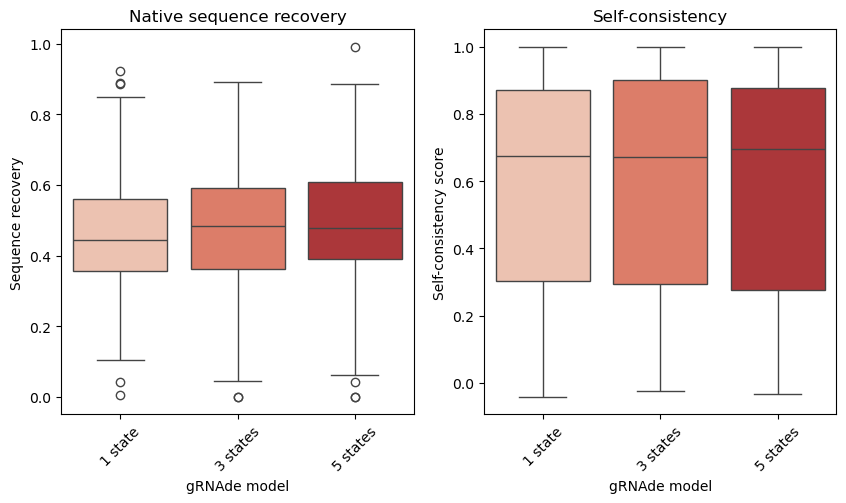

In [103]:
# boxplot comparing models on full test set

fig, ax = plt.subplots(ncols=2, sharex=False, sharey=False, figsize=(10, 5))
# fig.suptitle("title", fontsize=15)

for idx, metric in enumerate(["mean_recovery", "mean_scscore"]):
    sns.boxplot(
        data = df_sample,
        x="model_name",
        y=metric,
        # hue="set",
        saturation=0.65,
        palette="Reds",
        # whis=(0, 95),
        ax=ax[idx]
    )

    # sns.swarmplot(
    #     data = df_sample,
    #     x="model_name",
    #     y=metric,
    #     palette="Reds",
    #     ax=ax[idx],
    #     size=4
    # )

    # ax[0].get_legend().set_visible(False)
    ax[idx].set_title(metric, multialignment="right")

    # rotate x-axis labels
    ax[idx].tick_params('x', labelrotation=45)

ax[0].set_title("Native sequence recovery", multialignment="right")
ax[0].set_xlabel("gRNAde model")
ax[0].set_ylabel("Sequence recovery")

ax[1].set_title("Self-consistency", multialignment="right")
ax[1].set_xlabel("gRNAde model")
ax[1].set_ylabel("Self-consistency score")

plt.show()

# observations
    # naturally, we notice a drop in all metrics when using C4' only models
    # not limiting training to short sequences seems very important for 
    # good performance even though test set contains RNAs < 150 nts
    # AR_4layer C4' model seems like the best choice for future projects 

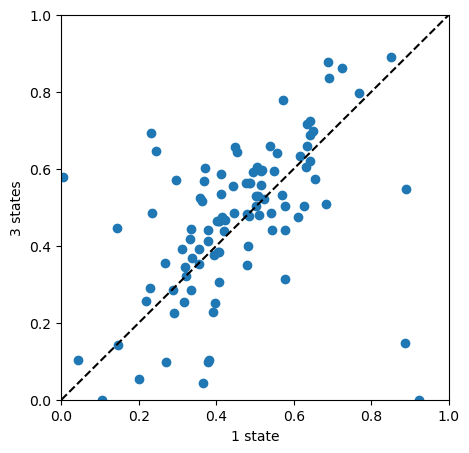

In [102]:
# scatterplot comparing Rosetta to models on individual test subset samples from the Das paper

model_x = "1 state"
model_y = "3 states"
metric = "mean_recovery"

# figure size square
plt.figure(figsize=(5, 5))

# sns.scatterplot(
#     x = df_sample_subset[df_sample_subset.model_name == model_x][metric],
#     y = df_sample_subset[df_sample_subset.model_name == model_y][metric],
# )
plt.scatter(
    df_sample[df_sample.model_name == model_x][metric],
    df_sample[df_sample.model_name == model_y][metric],
)

# set model names as x and y axis labels
plt.xlabel(model_x)
plt.ylabel(model_y)

# set x and y axis range to 0-1
plt.xlim(0, 1)
plt.ylim(0, 1)

# draw a line from (0,0) to (1,1)
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, ls="--", c="black")

plt.show()

array([[<Axes: title={'center': 'recovery'}>,
        <Axes: title={'center': 'sasa'}>],
       [<Axes: title={'center': 'paired'}>,
        <Axes: title={'center': 'rmsds'}>]], dtype=object)

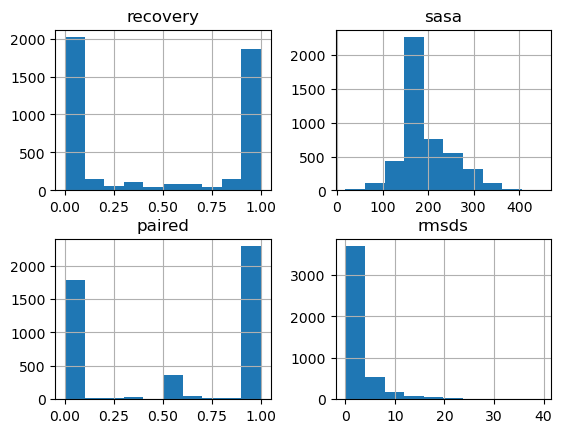

In [37]:
# overall histograms for residue level metrics
df_residue[df_residue.model_name == model_x].hist()

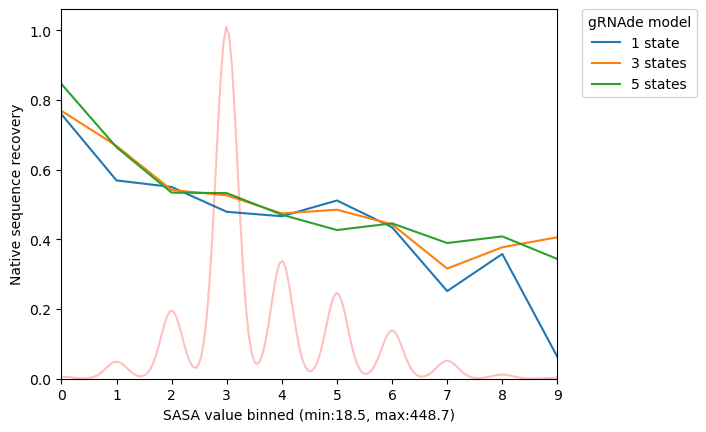

In [71]:
# recovery vs solvent accessable surface area of residue

# bin the values
num_bins = 10
df_residue['sasa_bin'] = pd.cut(df_residue['sasa'], bins=num_bins, labels=False)

ax = sns.lineplot(data=df_residue, x='sasa_bin', y='recovery', hue="model_name", errorbar=None)
sns.kdeplot(data=df_residue, x="sasa_bin", ax=ax, color='red', alpha=0.25)

# change x axis range
ax.set_xlim(0, num_bins - 1)

# move legend to top left and outside plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="gRNAde model")

ax.set_xlabel(f"SASA value binned (min:{df_residue.sasa.min():.1f}, max:{df_residue.sasa.max():.1f})")
ax.set_ylabel("Native sequence recovery")

plt.show()

In [68]:
np.arange(0, 1, 1/num_bins)

array([0. , 0.2, 0.4, 0.6, 0.8])

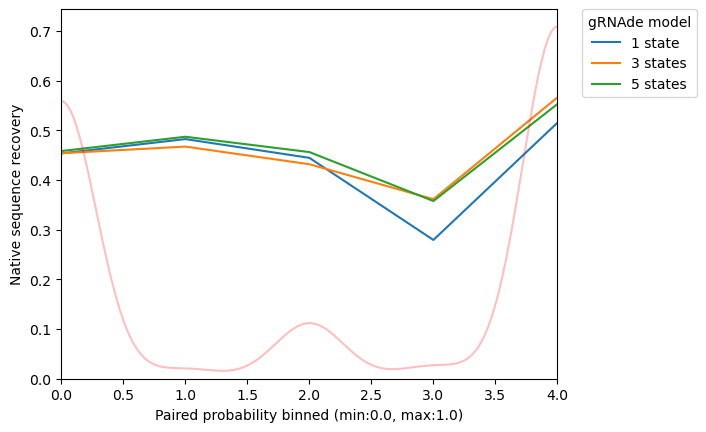

In [91]:
# recovery vs probability of residue being paired

# bin the values
num_bins = 5
df_residue['paired_bin'] = pd.cut(df_residue['paired'], bins=num_bins, labels=False)

ax = sns.lineplot(data=df_residue, x='paired_bin', y='recovery', hue="model_name", errorbar=None)
sns.kdeplot(data=df_residue, x="paired_bin", ax=ax, color='red', alpha=0.25)

# change x axis range
ax.set_xlim(0, num_bins - 1)

# move legend to top left and outside plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="gRNAde model")

ax.set_xlabel(f"Paired probability binned (min:{df_residue.paired.min():.1f}, max:{df_residue.paired.max():.1f})")
ax.set_ylabel("Native sequence recovery")

plt.show()

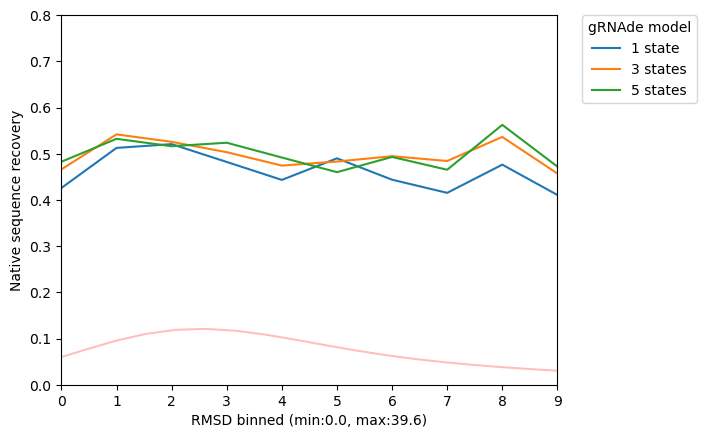

In [92]:
# recovery vs RMSD of residue if multiple structures are available

# bin the values
num_bins = 100
df_residue['rmsds_bin'] = pd.cut(df_residue['rmsds'], bins=num_bins, labels=False)

ax = sns.lineplot(data=df_residue, x='rmsds_bin', y='recovery', hue="model_name", errorbar=None)
sns.kdeplot(data=df_residue, x="rmsds_bin", ax=ax, color='red', alpha=0.25)

# change x axis range
# ax.set_xlim(0, num_bins - 1)
ax.set_xlim(0, 9)  # most of the later bins have very low density
ax.set_ylim(0, 0.8)

# move legend to top left and outside plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="gRNAde model")

ax.set_xlabel(f"RMSD binned (min:{df_residue.rmsds.min():.1f}, max:{df_residue.rmsds.max():.1f})")
ax.set_ylabel("Native sequence recovery")

plt.show()

array([[<Axes: title={'center': 'idx'}>,
        <Axes: title={'center': 'length'}>]], dtype=object)

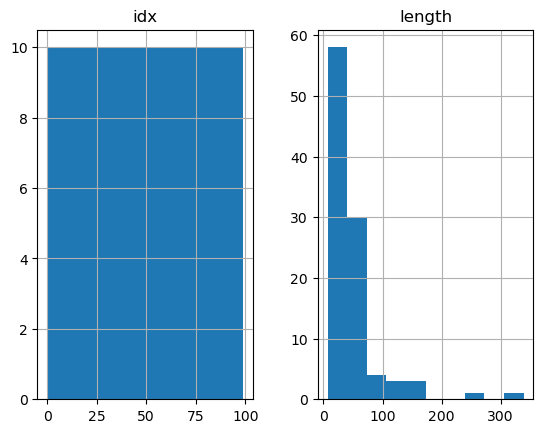

In [85]:
# for each unique combination of model_name, set, and idx, count the number of rows in df_residue with that combination

df_length = df_residue.groupby(["model_name", "set", "idx"]).count().reset_index()
df_length["length"] = df_length["recovery"]
df_length = df_length.drop(["recovery", "sasa", "paired", "rmsds", "sasa_bin", "paired_bin", "rmsds_bin"], axis=1)
df_length = df_length[df_length.model_name == model_x]
# use df_length to add length column to df_residue
df_residue["length"] = df_residue.apply(lambda row: df_length.loc[(df_length.set == row.set) & (df_length.idx == row.idx)].length.values[0], axis=1)
df_sample["length"] = df_length.length

df_length.hist()

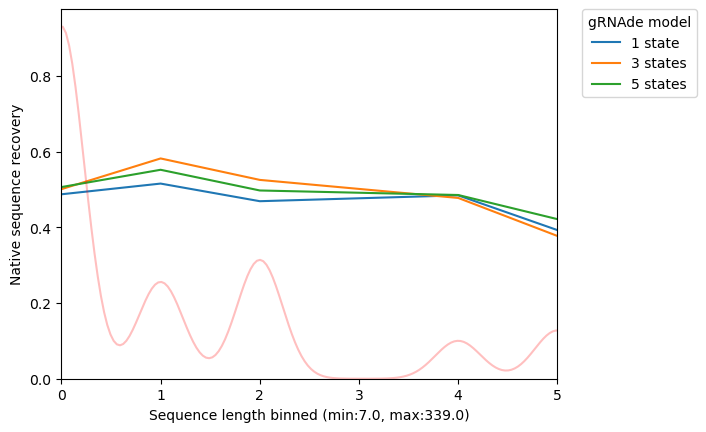

In [96]:
# residue-level recovery vs length of RNA sequence

# bin the values
num_bins = 6
df_residue['length_bin'] = pd.cut(df_residue['length'], bins=num_bins, labels=False)

ax = sns.lineplot(data=df_residue, x='length_bin', y='recovery', hue="model_name", errorbar=None)
sns.kdeplot(data=df_residue, x="length_bin", ax=ax, color='red', alpha=0.25)

# change x axis range
ax.set_xlim(0, num_bins - 1)

# move legend to top left and outside plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="gRNAde model")

ax.set_xlabel(f"Sequence length binned (min:{df_residue.length.min():.1f}, max:{df_residue.length.max():.1f})")
ax.set_ylabel("Native sequence recovery")

plt.show()